In [1]:
from helpers import *
from dataset import *
from model2 import *
from czii_helper import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import random
import torchvision.transforms as T
import cv2
import math
import cc3d
from torch.utils.data import Dataset, DataLoader
from monai.transforms import Compose, NormalizeIntensityd, ToTensorD
from scipy.optimize import linear_sum_assignment

In [2]:
mask_size2 = {key: math.floor(value * 0.7) for key, value in mask_size.items()}
mask_size2

{'defolt': 0,
 'apo-ferritin': 4,
 'beta-amylase': 4,
 'beta-galactosidase': 6,
 'ribosome': 10,
 'thyroglobulin': 9,
 'virus-like-particle': 9}

In [15]:
MODE = 'local'
valid_dir = '../input/czii-cryo-et-object-identification/train'

cfg = dotdict(
    arch ='resnet34d',
    checkpoint=\
    '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00010164-extern.pth',
   # '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-aug-noise-00003956.pth',
       #  '/kaggle/input/hengck-czii-cryo-et-weights-01/resnet34d-00002300.pth',
       # '/kaggle/input/hengck-czii-cryo-et-weights-01/00003531.pth',
    threshold={ 
        'apo-ferritin': 0.005,
        'beta-amylase': 0.005,
        'beta-galactosidase': 0.005,
        'ribosome': 0.005,
        'thyroglobulin': 0.005,
        'virus-like-particle': 0.005,
    },
)

(6, 184, 630, 630)
(6, 184, 630, 630)


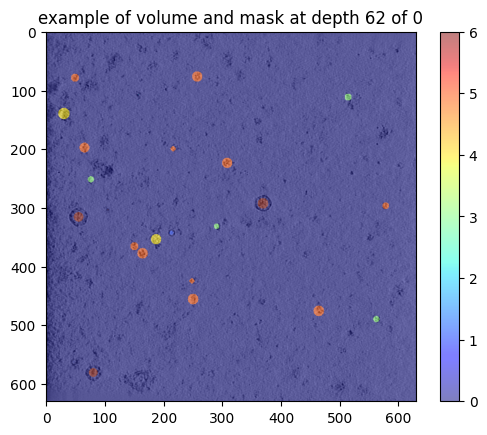

In [4]:
train_dir = '../input/czii-cryo-et-object-identification/train/static/ExperimentRuns/'
mask_dir = '../input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/'

valid_id = ['TS_99_9', "TS_6_4", "TS_6_6", "TS_69_2", "TS_73_6", "TS_86_3"]
#valid_id = ["TS_99_9"]
test_id = ["TS_5_4"]

volumes = np.empty((len(valid_id), 184, 630, 630), dtype=np.float32)
masks = np.empty((len(valid_id), 184, 630, 630), dtype=np.uint8)

for idx in range(len(valid_id)):
    data = read_one_data(valid_id[idx], train_dir)
    data = data.astype(np.float32)
    volumes[idx, :, :, :] = data
    
    y = read_one_truth(valid_id[idx], mask_dir)
    mask_data = generate_mask(y, mask_size2)
    mask_data = mask_data.astype(np.uint8)
    masks[idx, :, :, :] = mask_data

print(volumes.shape)
print(masks.shape)

print_slices(volumes, masks,dim=4,idx=0,depth=62)

In [5]:
vol_data = []
mask_data = []
for exp in range(len(valid_id)):
    vol_slices_list = []
    mask_slices_list = []

    volume = volumes[exp, :, :, :]
    mask = masks[exp, :, :, :]
    print("exp=", exp)
    
    #何もなし
    vol_slices,mask_slices=process_rotation_and_slicing(volume, mask, anglex=0, angley=0, anglez=0, zz_range=range(48, 184, 16))
    vol_slices_list.append(vol_slices)
    mask_slices_list.append(mask_slices)
    print("vol_slices shape:", vol_slices.shape)
    # 180度回転
    vol_slices,mask_slices=process_rotation_and_slicing(volume, mask, anglex=180, angley=0, anglez=0, zz_range=range(48, 184, 16))
    vol_slices_list.append(vol_slices)
    mask_slices_list.append(mask_slices)
    print("vol_slices shape:", vol_slices.shape)
    
    #反転
    vol_slices,mask_slices=process_rotation_and_slicing(volume, mask, anglex=180, angley=180, anglez=0, zz_range=range(48, 136, 16))
    vol_slices_list.append(vol_slices)
    mask_slices_list.append(mask_slices)
    print("vol_slices shape:", vol_slices.shape)

    #斜め
    vol_slices,mask_slices=process_rotation_and_slicing(volume, mask, anglex=5, angley=5, anglez=5, zz_range=range(48, 184, 16))
    vol_slices_list.append(vol_slices)
    mask_slices_list.append(mask_slices)
    print("vol_slices shape:", vol_slices.shape)


    combined_vol_slices = np.concatenate(vol_slices_list, axis=0)
    combined_mask_slices = np.concatenate(mask_slices_list, axis=0)

    vol_data.append(combined_vol_slices)
    mask_data.append(combined_mask_slices)

vol_data = np.concatenate(vol_data, axis=0)
mask_data = np.concatenate(mask_data, axis=0)

print("vol_data shape:", vol_data.shape)
print("mask_data shape:", mask_data.shape)

exp= 0
98 -5 44
-75 -27 28
11 62 12
47 75 -4
-99 -46 -20
-35 10 -36
-16 39 -52
-6 65 -68
9 -37 -84
vol_slices shape: (9, 32, 640, 640)
-10 28 44
43 21 28
-80 12 12
-80 72 -4
17 44 -20
-34 41 -36
57 61 -52
31 -67 -68
-14 -38 -84
vol_slices shape: (9, 32, 640, 640)
-94 -7 44
88 12 28
-24 9 12
-77 25 -4
64 -29 -20
85 42 -36
vol_slices shape: (6, 32, 640, 640)
-1 43 44
78 70 28
47 -17 12
-43 -90 -4
38 -18 -20
34 41 -36
9 -87 -52
-86 -69 -68
10 53 -84
vol_slices shape: (9, 32, 640, 640)
exp= 1
-72 -5 44
-39 28 28
26 0 12
94 65 -4
13 66 -20
75 -49 -36
-51 48 -52
85 13 -68
42 -71 -84
vol_slices shape: (9, 32, 640, 640)
-9 -32 44
-15 -15 28
-92 -92 12
-29 82 -4
-79 -92 -20
45 -56 -36
-8 -61 -52
3 -74 -68
45 -67 -84
vol_slices shape: (9, 32, 640, 640)
-30 -65 44
90 78 28
6 -16 12
67 88 -4
7 28 -20
-29 88 -36
vol_slices shape: (6, 32, 640, 640)
75 1 44
-32 -36 28
65 -59 12
-27 -68 -4
80 -53 -20
51 -15 -36
-81 14 -52
33 17 -68
6 49 -84
vol_slices shape: (9, 32, 640, 640)
exp= 2
30 30 44
82 100 28

In [6]:
class VolumeDataset(Dataset):
    def __init__(self, vol_data, mask_data, transform=None):
        """
        Args:
            vol_data (numpy.ndarray): 形状 (N, 32, 640, 640) を想定
            mask_data (numpy.ndarray): 形状 (N, 32, 640, 640) を想定
            transform (callable, optional): 
                MONAIの辞書ベースのTransformsなどを含むパイプライン。
        """
        self.vol_data = vol_data
        self.mask_data = mask_data
        self.transform = transform

    def __len__(self):
        # サンプル数を返す
        return len(self.vol_data)

    def __getitem__(self, idx):
        # 1. Pythonの辞書形式でデータを作る
        data_dict = {
            "image": self.vol_data[idx],  # (32, 640, 640)
            "label": self.mask_data[idx], # (32, 640, 640)
        }

        # 2. 辞書ベースのトランスフォームを適用
        if self.transform:
            data_dict = self.transform(data_dict)

        # 3. 変換後のデータを取り出して返す
        volume = data_dict["image"]
        mask   = data_dict["label"]

        return volume, mask


# --- 使い方の例 ---

# 変換の定義
# ToTensorD で numpy -> torch.Tensor に変換し、さらに正規化を行う
transforms = Compose([
    ToTensorD(keys=["image", "label"]),  # まずテンソルに変換
    NormalizeIntensityd(
        keys=["image"], 
        nonzero=False,      # ゼロ以外のボクセルに限定せず全体で正規化する例
        channel_wise=False  # チャネルごとの正規化をしない（1チャネル想定ならFalseでOK）
    ),
])


In [7]:
# Dataset のインスタンスを作成
dataset = VolumeDataset(vol_data, mask_data, transform=transforms)

# DataLoader のインスタンスを作成
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
net = Net(pretrained=True,cfg=None).cuda()

cuda


In [9]:
num_epochs = 20  # エポック数
learning_rate = 1e-3  # 学習率

optimizer = torch.optim.AdamW(
    net.parameters(), 
    lr=learning_rate,
    betas=(0.9, 0.999),
    capturable=False,
    differentiable= False,
    eps=1e-08,
    foreach=None,
    fused=None,
    weight_decay=0.01,
    )

# 損失を記録するリスト
epoch_losses = []

scaler = torch.cuda.amp.GradScaler(init_scale=4096)

for epoch in range(num_epochs):

    #5回ごとにoptimizerをリセットする
    if epoch % 5 == 0:
        optimizer = torch.optim.AdamW(
            net.parameters(), 
            lr=learning_rate,
            betas=(0.9, 0.999),
            capturable=False,
            differentiable= False,
            eps=1e-08,
            foreach=None,
            fused=None,
            weight_decay=0.01,
            )
        

    print(f"エポック {epoch + 1}/{num_epochs}")
    print("-" * 10)

    net.train()
    running_loss = 0.0

    for i, (volumes, masks) in enumerate(dataloader):
        batch = {
            'image': volumes.to(device).float(),
            'mask': masks.to(device).long(),
        }
        optimizer.zero_grad()

        with torch.amp.autocast("cuda", enabled=True):
            output = net(batch)
            loss = output['mask_loss']

        for k, v in output.items():
            if 'loss' in k:
                print(f'{k:>32} : {v.item()} ')    

        running_loss += loss.item()  # ミニバッチごとの損失を加算

        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

    # エポックごとの平均損失を計算して記録
    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"損失: {epoch_loss:.4f}")

`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


エポック 1/20
----------
                       mask_loss : 2.1098711490631104 
                       mask_loss : 2.0470516681671143 
                       mask_loss : 1.9802802801132202 
                       mask_loss : 2.015664577484131 
                       mask_loss : 1.9042952060699463 
                       mask_loss : 1.902488112449646 
                       mask_loss : 1.8128955364227295 
                       mask_loss : 1.7796380519866943 
                       mask_loss : 1.7558352947235107 
                       mask_loss : 1.7257866859436035 
                       mask_loss : 1.6841626167297363 
                       mask_loss : 1.6745884418487549 
                       mask_loss : 1.661496877670288 
                       mask_loss : 1.6360411643981934 
                       mask_loss : 1.619805932044983 
                       mask_loss : 1.6251857280731201 
                       mask_loss : 1.5760596990585327 
                       mask_loss : 1.56883180141

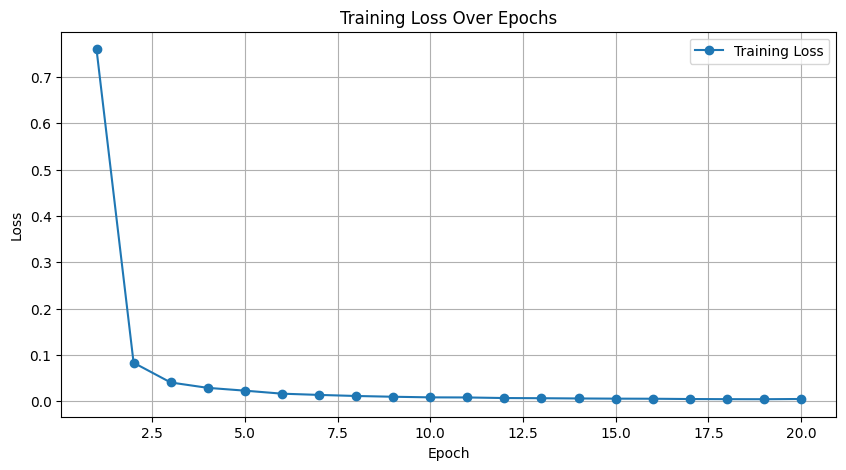

In [13]:
# 損失の推移をグラフ化
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
def probability_to_location(probability,cfg):
    _,D,H,W = probability.shape

    location={}
    for p in PARTICLE:
        p = dotdict(p)
        l = p.label

        cc, P = cc3d.connected_components(probability[l]>cfg.threshold[p.name], return_N=True)
        stats = cc3d.statistics(cc)
        zyx=stats['centroids'][1:]*10.012444
        xyz = np.ascontiguousarray(zyx[:,::-1]) 
        location[p.name]=xyz
        '''
            j=1
            z,y,x = np.where(cc==j)
            z=z.mean()
            y=y.mean()
            x=x.mean()
            print([x,y,z])
        '''
    return location

def location_to_df(location):
    location_df = []
    for p in PARTICLE:
        p = dotdict(p)
        xyz = location[p.name]
        if len(xyz)>0:
            df = pd.DataFrame(data=xyz, columns=['x','y','z'])
            #df.loc[:,'particle_type']= p.name
            df.insert(loc=0, column='particle_type', value=p.name)
            location_df.append(df)
    location_df = pd.concat(location_df)
    return location_df


#start here !!!! ====================================================================================
def run_submit():
    
    net.cuda()
    net.eval()
    net.output_type = ['infer']

    submit_df = []
    start_timer = timer()
    for i,id in enumerate(test_id):
        print(i, id, '---------------')
        volume = read_one_data(id, static_dir=f'{valid_dir}/static/ExperimentRuns')
        D, H, W = volume.shape
        print(D, H, W)

        probability = np.zeros((7, D, H, W), dtype=np.float32)
        count = np.zeros((7, D, H, W), dtype=np.float32)
        pad_volume = np.pad(volume, [[0, 0], [0, 640 - H], [0, 640 - W]], mode='constant', constant_values=0)
        
        num_slice=64
        zz = list(range(0, D - num_slice, num_slice//2)) + [D - num_slice]
        for z in zz:
            print('\r',f'z:{z}', end='',flush=True)
            image = pad_volume[z:z + num_slice]
            batch = dotdict(
                image=torch.from_numpy(image).unsqueeze(0),
            )
            with torch.amp.autocast('cuda', enabled=True):
                with torch.no_grad():
                    output = net(batch)
            prob = output['particle'][0].cpu().numpy()
            probability[:, z:z + num_slice] += prob[:, :, :H, :W]
            count[:, z:z + num_slice] += 1
        probability = probability / (count + 0.0001)
        location = probability_to_location(probability, cfg)
        df = location_to_df(location)
        df.insert(loc=0, column='experiment', value=id)
        submit_df.append(df)
        print('')
        print(time_to_str(timer() - start_timer, 'sec'))

    print('\ndone!')
    total_time = timer() - start_timer
    num_volume = len(test_id)
    print(f'Total time for {num_volume} volumes:', time_to_str(total_time, 'min'))
    print(f'Total time for 500 volumes:', time_to_str(total_time/num_volume*500, 'min'))
    print('')
    submit_df = pd.concat(submit_df)
    submit_df.insert(loc=0, column='id', value=np.arange(len(submit_df)))
    return submit_df



if 1:
    submit_df = run_submit()
    print('submit_df', submit_df.shape)
    print(submit_df)
    submit_df.to_csv('submission.csv', index=False)

#!ls
print('SUBMIT OK!!!')

0 TS_5_4 ---------------
184 630 630
 z:120

ValueError: No objects to concatenate

: 

['TS_99_9']
 TS_99_9 virus-like-particle


         particle_type  P   T  hit  miss  fp  precision  recall  f-beta4  \
0         apo-ferritin  0  36    0    36   0        0.0     0.0      0.0   
1         beta-amylase  0  21    0    21   0        0.0     0.0      0.0   
2   beta-galactosidase  0  24    0    24   0        0.0     0.0      0.0   
3             ribosome  5  65    0    65   5        0.0     0.0      0.0   
4        thyroglobulin  0  49    0    49   0        0.0     0.0      0.0   
5  virus-like-particle  0  13    0    13   0        0.0     0.0      0.0   

   weight  
0       1  
1       0  
2       2  
3       1  
4       2  
5       1  
lb_score: 0.0

TS_99_9 apo-ferritin
	 num truth   : 36
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 36
TS_99_9 beta-amylase
	 num truth   : 21
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 21
TS_99_9 beta-galactosidase
	 num truth   : 24
	 num predict : 0
	 num hit  : 0
	 num fp   : 0
	 num miss : 24
TS_99_9 ribosome
	 num truth   : 65
	 num predict

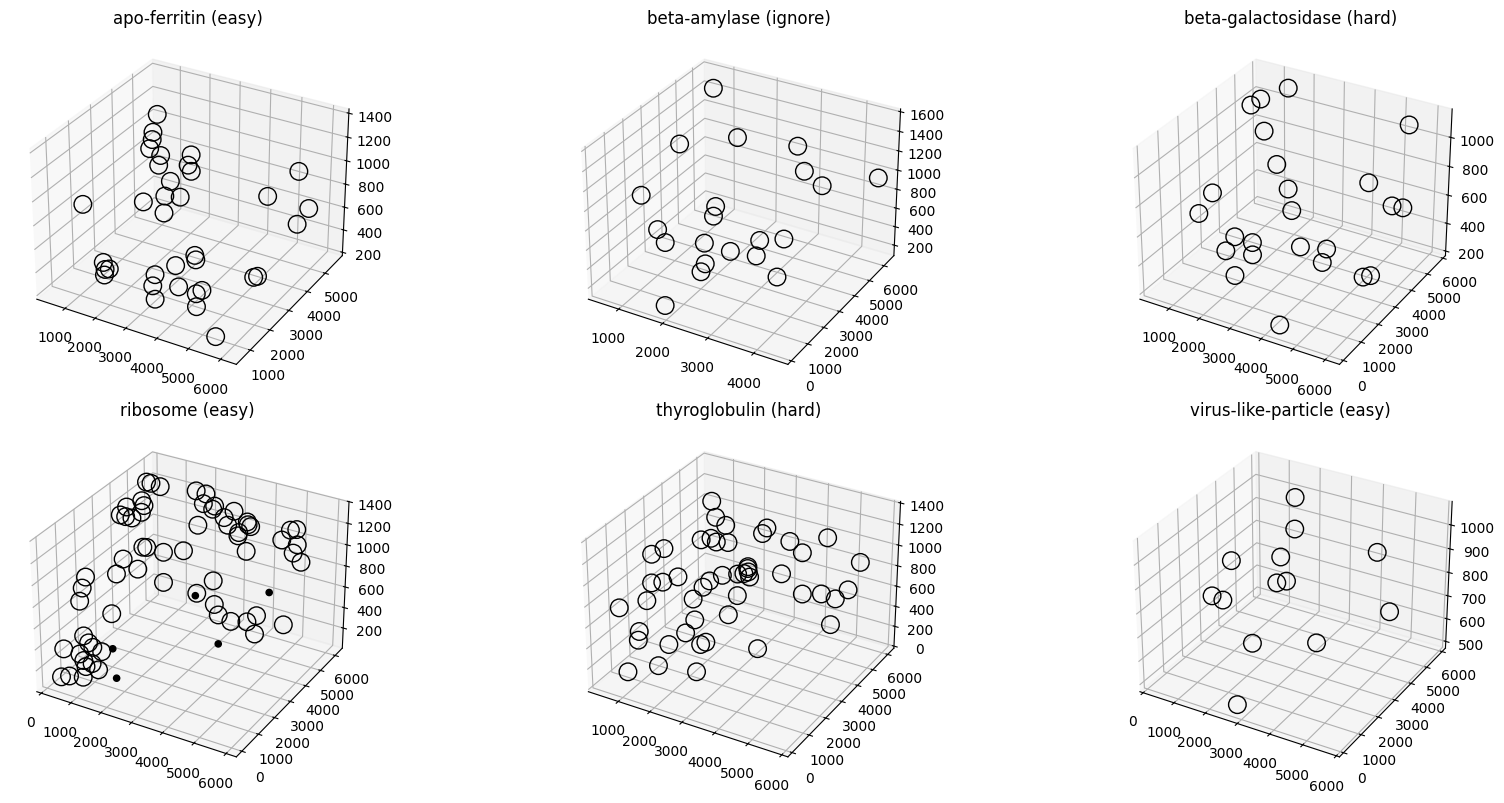

In [ ]:
MODE = 'local'
valid_dir = '../input/czii-cryo-et-object-identification/train'

def do_one_eval(truth, predict, threshold):
    P=len(predict)
    T=len(truth)

    if P==0:
        hit=[[],[]]
        miss=np.arange(T).tolist()
        fp=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    if T==0:
        hit=[[],[]]
        fp=np.arange(P).tolist()
        miss=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    #---
    distance = predict.reshape(P,1,3)-truth.reshape(1,T,3)
    distance = distance**2
    distance = distance.sum(axis=2)
    distance = np.sqrt(distance)
    p_index, t_index = linear_sum_assignment(distance)

    valid = distance[p_index, t_index] <= threshold
    p_index = p_index[valid]
    t_index = t_index[valid]
    hit = [p_index.tolist(), t_index.tolist()]
    miss = np.arange(T)
    miss = miss[~np.isin(miss,t_index)].tolist()
    fp = np.arange(P)
    fp = fp[~np.isin(fp,p_index)].tolist()

    metric = [P,T,len(hit[0]),len(miss),len(fp)] #for lb metric F-beta copmutation
    return hit, fp, miss, metric


def compute_lb(submit_df, overlay_dir):
    valid_id = list(submit_df['experiment'].unique())
    print(valid_id)

    eval_df = []
    for id in valid_id:
        truth = read_one_truth(id, overlay_dir) #=f'{valid_dir}/overlay/ExperimentRuns')
        id_df = submit_df[submit_df['experiment'] == id]
        for p in PARTICLE:
            p = dotdict(p)
            print('\r', id, p.name, end='', flush=True)
            xyz_truth = truth[p.name]
            xyz_predict = id_df[id_df['particle_type'] == p.name][['x', 'y', 'z']].values
            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius* 0.5)
            eval_df.append(dotdict(
                id=id, particle_type=p.name,
                P=metric[0], T=metric[1], hit=metric[2], miss=metric[3], fp=metric[4],
            ))
    print('')
    eval_df = pd.DataFrame(eval_df)
    gb = eval_df.groupby('particle_type').agg('sum').drop(columns=['id'])
    gb.loc[:, 'precision'] = gb['hit'] / gb['P']
    gb.loc[:, 'precision'] = gb['precision'].fillna(0)
    gb.loc[:, 'recall'] = gb['hit'] / gb['T']
    gb.loc[:, 'recall'] = gb['recall'].fillna(0)
    gb.loc[:, 'f-beta4'] = 17 * gb['precision'] * gb['recall'] / (16 * gb['precision'] + gb['recall'])
    gb.loc[:, 'f-beta4'] = gb['f-beta4'].fillna(0)

    gb = gb.sort_values('particle_type').reset_index(drop=False)
    # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
    gb.loc[:, 'weight'] = [1, 0, 2, 1, 2, 1]
    lb_score = (gb['f-beta4'] * gb['weight']).sum() / gb['weight'].sum()
    return gb, lb_score


#debug
if 1:
    if MODE=='local':
    #if 1:
        submit_df=pd.read_csv(
           'submission.csv'
            # '/kaggle/input/hengck-czii-cryo-et-weights-01/submission.csv'
        )
        gb, lb_score = compute_lb(submit_df, f'{valid_dir}/overlay/ExperimentRuns')
        print(gb)
        print('lb_score:',lb_score)
        print('')


        #show one ----------------------------------
        fig = plt.figure(figsize=(18, 8))

        id = valid_id[0]
        truth = read_one_truth(id,overlay_dir=f'{valid_dir}/overlay/ExperimentRuns')

        submit_df = submit_df[submit_df['experiment']==id]
        for p in PARTICLE:
            p = dotdict(p)
            xyz_truth = truth[p.name]
            xyz_predict = submit_df[submit_df['particle_type']==p.name][['x','y','z']].values
            hit, fp, miss, _ = do_one_eval(xyz_truth, xyz_predict, p.radius)
            print(id, p.name)
            print('\t num truth   :',len(xyz_truth) )
            print('\t num predict :',len(xyz_predict) )
            print('\t num hit  :',len(hit[0]) )
            print('\t num fp   :',len(fp) )
            print('\t num miss :',len(miss) )

            ax = fig.add_subplot(2, 3, p.label, projection='3d')
            if hit[0]:
                pt = xyz_predict[hit[0]]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=0.5, color='r')
                pt = xyz_truth[hit[1]]
                ax.scatter(pt[:,0], pt[:,1], pt[:,2], s=80, facecolors='none', edgecolors='r')
            if fp:
                pt = xyz_predict[fp]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=1, color='k')
            if miss:
                pt = xyz_truth[miss]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], s=160, alpha=1, facecolors='none', edgecolors='k')

            ax.set_title(f'{p.name} ({p.difficulty})')

        plt.tight_layout()
        plt.show()
        
        #--- 
        zz=0